In [15]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Đọc file dữ liệu
df = pd.read_csv("C:\\Users\\ADMIN\\Desktop\\VTB.csv")

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.7 * len(df))
test_size = len(df1) - train_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

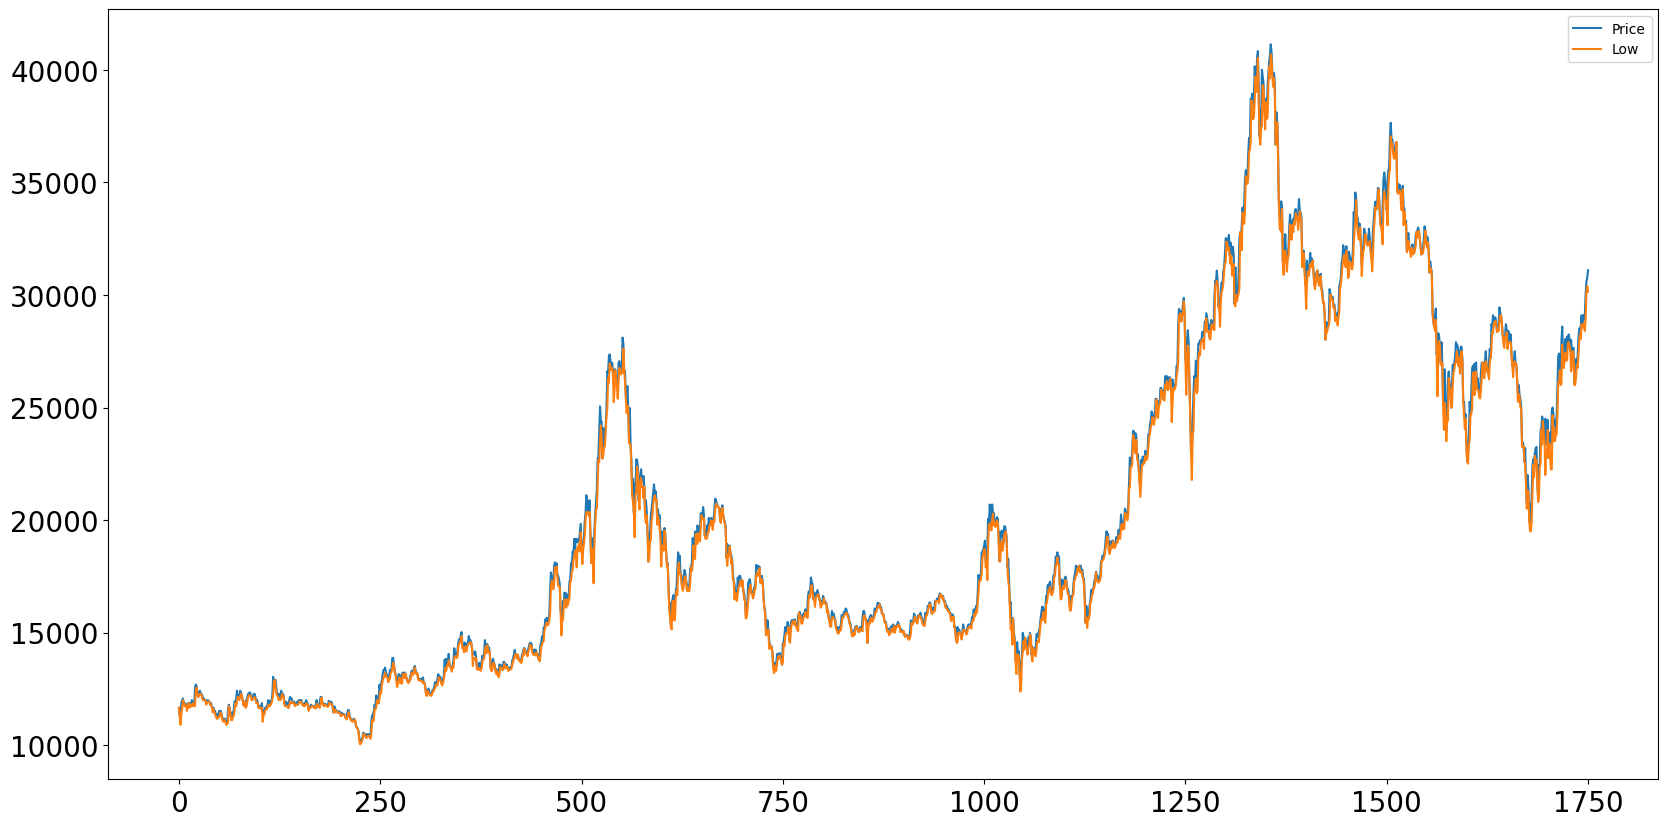

In [17]:
# Xem lại dataset
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

In [18]:
# Tìm m thích hợp
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.2482487299115146,
 0.6525038496876456,
 1,
 1749,
 {'1%': -3.4340943816187823,
  '5%': -2.8631939359068803,
  '10%': -2.5676505066098376},
 26447.68585277919)

In [19]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [20]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-43.48255524609407,
 0.0,
 0,
 1749,
 {'1%': -3.4340943816187823,
  '5%': -2.8631939359068803,
  '10%': -2.5676505066098376},
 26432.797064761224)

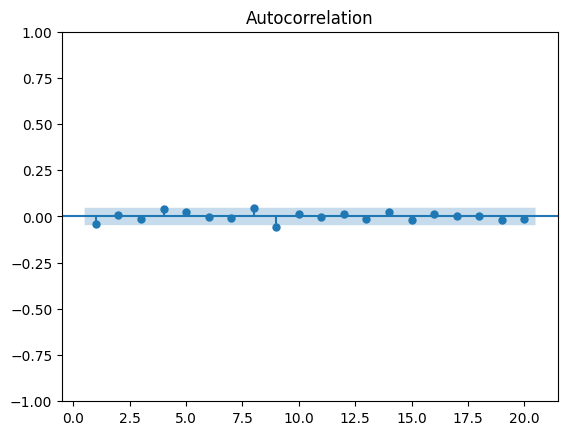

In [21]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

In [22]:
df

,Price,Low
0,11656,11656
1,11311,11242
2,11104,10897
3,11862,11380
4,12000,11587
...,...,...
1746,29100,28400
1747,30000,28900
1748,30600,30100
1749,30750,30400


In [23]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic


In [ ]:
# Dùng SARIMAX để train model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(2,1,2), seasonal_order=(1, 0, 0, 5))
model_fit = model1.fit()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Quá trình test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([15800., 15800., 16250., 16400., 16650., 16900., 16900., 16700.,
       15800., 16250., 16550., 16600., 16800., 16750., 16900., 17450.,
       17700., 17850., 18650., 19800., 19500., 19400., 19000., 20500.,
       20250., 19200., 17950., 18850., 19700., 19350., 18050., 17000.,
       16050., 15500., 16100., 16000., 17150., 17550., 17600., 17100.,
       17100., 18200., 18450., 18250., 18550., 18500., 18300., 18200.,
       18200., 18500., 19050., 19000., 18300., 18150., 18500., 18300.,
       18400., 18850., 19000., 18900., 18750., 19000., 19600., 19550.,
       19150., 18750., 18300., 18450., 18300., 18900., 19000., 21250.,
       21100., 21800., 22600., 22600., 22100., 22000., 22200., 22750.,
       22600., 22200., 22200., 21800., 22000., 22300., 21000., 20900.,
       22450., 22300., 22900., 23850., 23150., 24050., 24300., 23800.,
       23700., 24450., 24800., 26050., 26150., 25850., 25650., 27300.,
       28100., 28800., 28800., 28900., 29350., 29000., 30000., 31900.,
      

In [ ]:
# Quá trình tạo index predict 30 ngày tiếp theo
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Price'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị price 30 ngày tiếp theo
price_next_30_days = ln_model.predict(x_next_30_days)

# Predict prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=price_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted prices for the next 30 days:')
print(y_next_30_days)

Predicted prices for the next 30 days:
[12321.79306966 12322.43963504 12323.08620042 12323.7327658
 12324.37933118 12325.02589656 12325.67246194 12326.31902732
 12326.9655927  12327.61215808 12328.25872346 12328.90528884
 12329.55185422 12330.1984196  12330.84498498 12331.49155036
 12332.13811574 12332.78468112 12333.4312465  12334.07781188
 12334.72437725 12335.37094263 12336.01750801 12336.66407339
 12337.31063877 12337.95720415 12338.60376953 12339.25033491
 12339.89690029 12340.54346567]


In [ ]:
# Đánh giá độ chính xác thuật toán với MAPE
# RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

# MAPE (thay thế MSE bằng MAPE)
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

# MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)


Testing RMSE: 630.1216009145867
Testing MAPE: 1.8147370245371361
Testing MAE: 442.7756653992381


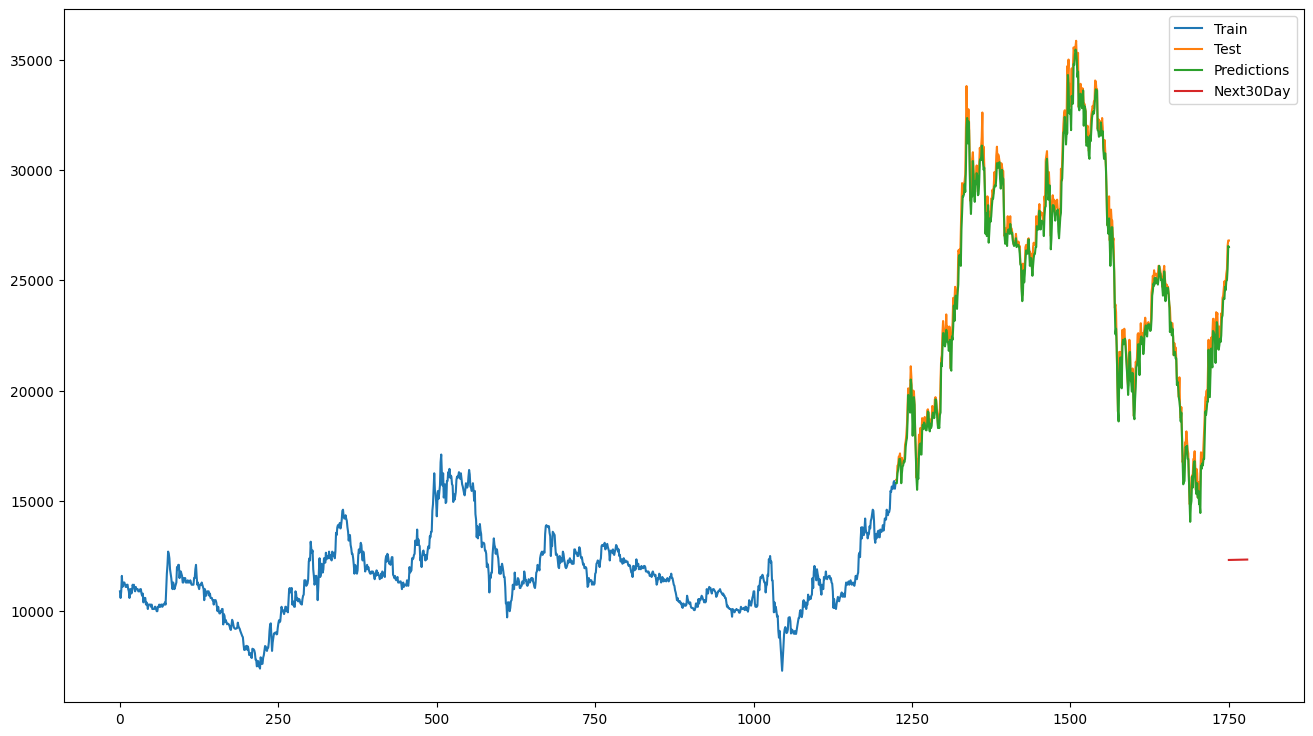

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()